# LLM vs Rule-Based Extraction: Differences Notebook

This notebook reproduces the key differences described in `docs/LLM_approach.md` by comparing:
- Rule-based output
- LLM output

It focuses on completeness, section-level field differences, duplicates, and approval data extraction.

In [1]:
from pathlib import Path
import json
from collections import Counter
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 120)

ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
RULE_PATH = ROOT / 'data/processed/schema_output/diler-07-07-2025-rerun-41-44_schema_output.json'
LLM_PATH = ROOT / 'data/processed/schema_output/llm_certificate_full.json'

print('Rule-based path:', RULE_PATH)
print('LLM path:', LLM_PATH)
print('Rule exists:', RULE_PATH.exists())
print('LLM exists:', LLM_PATH.exists())

Rule-based path: /workspaces/mtc-extraction-benchmark/data/processed/schema_output/diler-07-07-2025-rerun-41-44_schema_output.json
LLM path: /workspaces/mtc-extraction-benchmark/data/processed/schema_output/llm_certificate_full.json
Rule exists: True
LLM exists: True


In [10]:
with open(RULE_PATH, 'r', encoding='utf-8') as f:
    rule_data = json.load(f)

with open(LLM_PATH, 'r', encoding='utf-8') as f:
    llm_data = json.load(f)

print('Loaded rule-based and LLM JSON files successfully.')

Loaded rule-based and LLM JSON files successfully.


## 1) Top-Level Structure Comparison

In [11]:
rule_keys = set(rule_data.keys())
llm_keys = set(llm_data.keys())

pd.DataFrame({
    'present_in_rule_based': [k in rule_keys for k in sorted(rule_keys | llm_keys)],
    'present_in_llm': [k in llm_keys for k in sorted(rule_keys | llm_keys)]
}, index=sorted(rule_keys | llm_keys))

,present_in_rule_based,present_in_llm
approval,True,True
chemical_composition,True,True
document,True,True
mechanical_properties,True,True
product,True,True
traceability,True,True


## 2) Document / Traceability / Product Field Differences

In [12]:
def compare_dict_fields(section_name, rule_obj, llm_obj):
    all_fields = sorted(set(rule_obj.keys()) | set(llm_obj.keys()))
    rows = []
    for field in all_fields:
        r = rule_obj.get(field)
        l = llm_obj.get(field)
        rows.append({
            'section': section_name,
            'field': field,
            'rule_based': r,
            'llm': l,
            'same': r == l
        })
    return rows

rows = []
rows += compare_dict_fields('document', rule_data.get('document', {}), llm_data.get('document', {}))
rows += compare_dict_fields('traceability', rule_data.get('traceability', {}), llm_data.get('traceability', {}))
rows += compare_dict_fields('product', rule_data.get('product', {}), llm_data.get('product', {}))

df_basic = pd.DataFrame(rows)
df_basic

,section,field,rule_based,llm,same
0,document,certificate_number,25-3133/01MNF/EXP,25-3133/01MNF/EXP,True
1,document,customer,MW STEEL TRADING LIMITED,MW STEEL TRADING LIMITED LONDON THAMESPORT LIBERTY,False
2,document,issuing_date,2025-07-07,2025-07-07,True
3,document,order_number,MK250508-001,MK250508-001,True
4,document,standard,EN 10204 3.1,EN 10204 3.1,True
5,traceability,consignment_number,2025-3133/01,2025-3133/01,True
6,traceability,heat_number,None,None,True
7,traceability,lot_number,1,2025-3133 LOT-1,False
8,traceability,vessel_name,MV WHITE IVY,MV WHITE IVY,True
9,product,production_process,QST,QST,True


## 3) Chemical Composition Coverage & Completeness

In [13]:
required_elements = ['C','Si','P','S','Mn','Ni','Cr','Mo','Cu','V','N','B','Ce']

def chem_stats(data):
    chems = data.get('chemical_composition', [])
    heats = [str(item.get('heat_number')) for item in chems if item.get('heat_number') is not None]

    complete = 0
    details = []
    for item in chems:
        h = str(item.get('heat_number'))
        elements_obj = item.get('elements', item)
        missing = [e for e in required_elements if elements_obj.get(e) is None]
        is_complete = len(missing) == 0
        complete += int(is_complete)
        details.append({'heat_number': h, 'is_complete': is_complete, 'missing_elements': missing})

    return {
        'count_heat_rows': len(chems),
        'unique_heat_numbers': len(set(heats)),
        'complete_heat_rows': complete,
        'details_df': pd.DataFrame(details).sort_values('heat_number') if details else pd.DataFrame()
    }

rule_chem = chem_stats(rule_data)
llm_chem = chem_stats(llm_data)

pd.DataFrame([
    {'method': 'rule_based', 'heat_rows': rule_chem['count_heat_rows'], 'unique_heats': rule_chem['unique_heat_numbers'], 'complete_heats': rule_chem['complete_heat_rows']},
    {'method': 'llm', 'heat_rows': llm_chem['count_heat_rows'], 'unique_heats': llm_chem['unique_heat_numbers'], 'complete_heats': llm_chem['complete_heat_rows']}
])

,method,heat_rows,unique_heats,complete_heats
0,rule_based,6,6,6
1,llm,20,20,11


In [14]:
print('LLM heat rows with missing chemical elements:')
llm_chem['details_df'][~llm_chem['details_df']['is_complete']].head(20)

LLM heat rows with missing chemical elements:


,heat_number,is_complete,missing_elements
18,2500812,False,"[N, B, Ce]"
9,2504095,False,"[Mn, Ni, Cr, Mo, Cu, V, N, B, Ce]"
8,25990024,False,"[Cu, V, N, B, Ce]"
7,25990031,False,"[Ni, Cr, Mo, Cu, V, N, B, Ce]"
4,25990035,False,[B]
3,25990039,False,[B]
2,25990040,False,[B]
1,25990041,False,[B]
0,25990085,False,[B]


## 4) Mechanical Properties Coverage & Duplicate Check

In [15]:
def mech_stats(data):
    mech = data.get('mechanical_properties', [])
    key_fields = ['heat_number', 'test_sample', 'weight_kg_per_m', 'cross_sectional_area_mm2', 'yield_point_mpa', 'tensile_strength_mpa', 'rm_re_ratio', 'percentage_elongation', 'agt_percent']

    keys = []
    rebend_count = 0
    for row in mech:
        keys.append(tuple(row.get(k) for k in key_fields))
        if row.get('rebend') is not None:
            rebend_count += 1

    total = len(mech)
    unique = len(set(keys))
    duplicates = total - unique

    return {'total_rows': total, 'unique_rows': unique, 'duplicate_rows': duplicates, 'rebend_rows': rebend_count}

rule_mech = mech_stats(rule_data)
llm_mech = mech_stats(llm_data)

pd.DataFrame([
    {'method': 'rule_based', **rule_mech},
    {'method': 'llm', **llm_mech},
])

,method,total_rows,unique_rows,duplicate_rows,rebend_rows
0,rule_based,58,29,29,0
1,llm,80,80,0,40


## 5) Approval Section Comparison

In [16]:
approval_rows = compare_dict_fields('approval', rule_data.get('approval', {}), llm_data.get('approval', {}))
pd.DataFrame(approval_rows)

,section,field,rule_based,llm,same
0,approval,cares_approved,True,True,True
1,approval,certificate_of_approval_number,None,O11001,False
2,approval,form_number,None,C8.03 2-4/R-0,False


## 6) Quick Summary (Data-Driven)

In [17]:
summary = pd.DataFrame([
    {
        'metric': 'chemical_unique_heat_numbers',
        'rule_based': rule_chem['unique_heat_numbers'],
        'llm': llm_chem['unique_heat_numbers'],
        'delta_llm_minus_rule': llm_chem['unique_heat_numbers'] - rule_chem['unique_heat_numbers']
    },
    {
        'metric': 'mechanical_total_rows',
        'rule_based': rule_mech['total_rows'],
        'llm': llm_mech['total_rows'],
        'delta_llm_minus_rule': llm_mech['total_rows'] - rule_mech['total_rows']
    },
    {
        'metric': 'mechanical_duplicate_rows',
        'rule_based': rule_mech['duplicate_rows'],
        'llm': llm_mech['duplicate_rows'],
        'delta_llm_minus_rule': llm_mech['duplicate_rows'] - rule_mech['duplicate_rows']
    },
    {
        'metric': 'approval_fields_present',
        'rule_based': sum(v is not None for v in rule_data.get('approval', {}).values()),
        'llm': sum(v is not None for v in llm_data.get('approval', {}).values()),
        'delta_llm_minus_rule': sum(v is not None for v in llm_data.get('approval', {}).values()) - sum(v is not None for v in rule_data.get('approval', {}).values())
    }
])
summary

,metric,rule_based,llm,delta_llm_minus_rule
0,chemical_unique_heat_numbers,6,20,14
1,mechanical_total_rows,58,80,22
2,mechanical_duplicate_rows,29,0,-29
3,approval_fields_present,1,3,2


## 7) Advanced Visual Analytics (Repo-wide)

These visuals use additional repository artifacts (OCR boxes and text files) to provide richer comparisons beyond the schema outputs.

In [ ]:
# 7.0 Core metric bar chart
plot_df = summary.copy()
metrics = plot_df['metric'].tolist()
x = np.arange(len(metrics))
width = 0.38

fig, ax = plt.subplots(figsize=(10, 4.8))
ax.bar(x - width/2, plot_df['rule_based'], width, label='Rule-based')
ax.bar(x + width/2, plot_df['llm'], width, label='LLM')
ax.set_title('Core Comparison Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=20, ha='right')
ax.set_ylabel('Value')
ax.legend()
ax.grid(axis='y', alpha=0.25)
plt.tight_layout()
plt.show()

### 7.1 Field Completeness Heatmap (Core Sections)

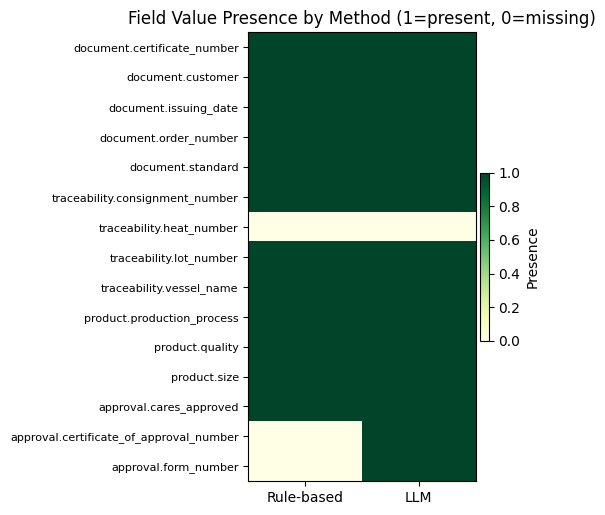

,rule_presence_rate,llm_presence_rate
section,,
approval,0.333333,1.00
document,1.000000,1.00
product,1.000000,1.00
traceability,0.750000,0.75


In [18]:
sections = ['document', 'traceability', 'product', 'approval']
all_rows = []
for section in sections:
    r = rule_data.get(section, {})
    l = llm_data.get(section, {})
    fields = sorted(set(r.keys()) | set(l.keys()))
    for f in fields:
        all_rows.append({
            'section': section,
            'field': f,
            'rule_present': 1 if r.get(f) is not None else 0,
            'llm_present': 1 if l.get(f) is not None else 0
        })

field_df = pd.DataFrame(all_rows)
heat = field_df.set_index(['section', 'field'])[['rule_present', 'llm_present']]

fig, ax = plt.subplots(figsize=(5.6, max(4, len(heat) * 0.35)))
im = ax.imshow(heat.values, aspect='auto', vmin=0, vmax=1, cmap='YlGn')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Rule-based', 'LLM'])
ax.set_yticks(np.arange(len(heat.index)))
ax.set_yticklabels([f'{s}.{f}' for s, f in heat.index], fontsize=8)
ax.set_title('Field Value Presence by Method (1=present, 0=missing)')
cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label('Presence')
plt.tight_layout()
plt.show()

field_df.groupby('section')[['rule_present', 'llm_present']].mean().rename(columns={'rule_present':'rule_presence_rate', 'llm_present':'llm_presence_rate'})

### 7.2 OCR Confidence Distribution by Page (from boxes)

/tmp/ipykernel_22592/2210896667.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_for_box, labels=[str(p) for p in sorted(boxes_df['page'].unique())], showfliers=False)


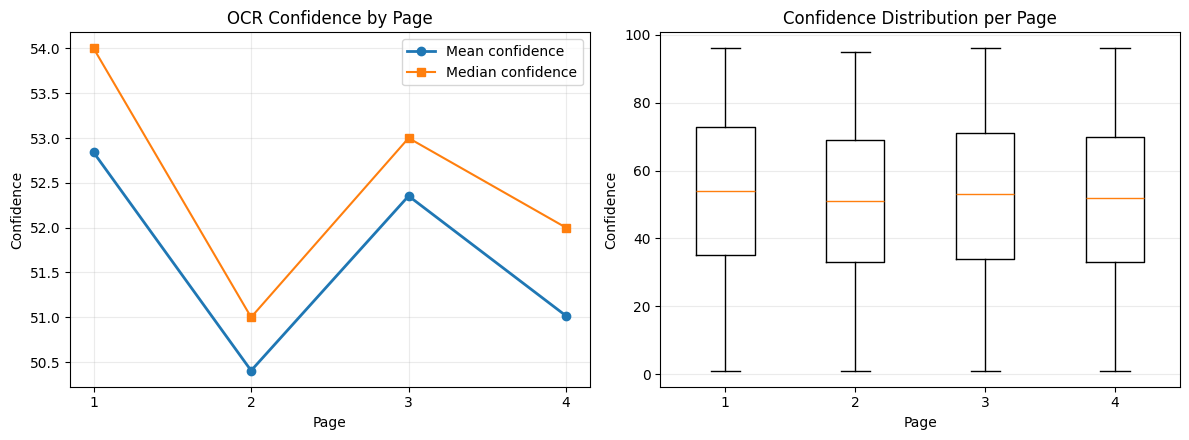

In [19]:
boxes_dir = ROOT / 'data/processed/boxes'
box_files = sorted(boxes_dir.glob('page_*.json'))

box_rows = []
for p in box_files:
    page_num = int(re.search(r'page_(\d+)', p.stem).group(1))
    items = json.loads(p.read_text())
    for item in items:
        box_rows.append({
            'page': page_num,
            'conf': float(item.get('conf', np.nan)),
            'x': float(item.get('x', np.nan)),
            'y': float(item.get('y', np.nan)),
            'w': float(item.get('w', np.nan)),
            'h': float(item.get('h', np.nan)),
            'text_len': len(str(item.get('text', '')))
        })

boxes_df = pd.DataFrame(box_rows).dropna(subset=['conf'])
boxes_df['area'] = boxes_df['w'] * boxes_df['h']

page_conf = boxes_df.groupby('page')['conf'].agg(['count', 'mean', 'median', 'min', 'max']).reset_index()
page_conf

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

axes[0].plot(page_conf['page'], page_conf['mean'], marker='o', linewidth=2, label='Mean confidence')
axes[0].plot(page_conf['page'], page_conf['median'], marker='s', linewidth=1.5, label='Median confidence')
axes[0].set_title('OCR Confidence by Page')
axes[0].set_xlabel('Page')
axes[0].set_ylabel('Confidence')
axes[0].set_xticks(page_conf['page'])
axes[0].grid(alpha=0.25)
axes[0].legend()

data_for_box = [boxes_df.loc[boxes_df['page'] == p, 'conf'].values for p in sorted(boxes_df['page'].unique())]
axes[1].boxplot(data_for_box, labels=[str(p) for p in sorted(boxes_df['page'].unique())], showfliers=False)
axes[1].set_title('Confidence Distribution per Page')
axes[1].set_xlabel('Page')
axes[1].set_ylabel('Confidence')
axes[1].grid(axis='y', alpha=0.25)

plt.tight_layout()
plt.show()

### 7.3 OCR Spatial Maps (Token Density + Mean Confidence)

These are heat maps over normalized page coordinates, aggregated across all pages.

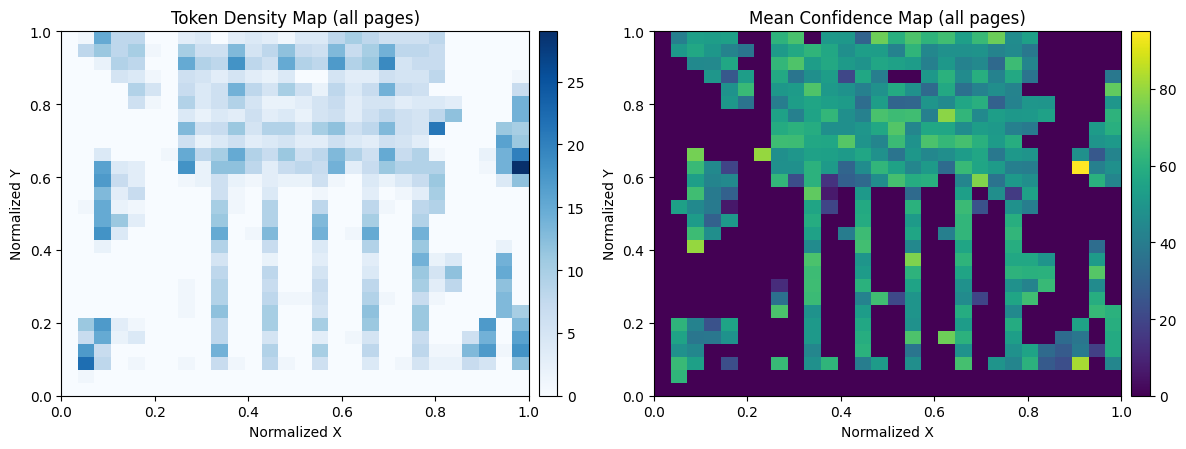

In [20]:
# Normalize coordinates by per-page extents so all pages can be overlaid
norm_parts = []
for p in sorted(box_files):
    page_num = int(re.search(r'page_(\d+)', p.stem).group(1))
    items = json.loads(p.read_text())
    page_df = pd.DataFrame(items)
    if page_df.empty:
        continue
    page_df['x_center'] = page_df['x'] + page_df['w'] / 2
    page_df['y_center'] = page_df['y'] + page_df['h'] / 2
    max_x = (page_df['x'] + page_df['w']).max()
    max_y = (page_df['y'] + page_df['h']).max()
    page_df['x_norm'] = page_df['x_center'] / max_x if max_x else 0
    page_df['y_norm'] = page_df['y_center'] / max_y if max_y else 0
    page_df['page'] = page_num
    norm_parts.append(page_df[['page', 'x_norm', 'y_norm', 'conf']])

norm_df = pd.concat(norm_parts, ignore_index=True)

bins = 28
density, xedges, yedges = np.histogram2d(norm_df['x_norm'], norm_df['y_norm'], bins=bins, range=[[0, 1], [0, 1]])
weighted, _, _ = np.histogram2d(norm_df['x_norm'], norm_df['y_norm'], bins=bins, range=[[0, 1], [0, 1]], weights=norm_df['conf'])
mean_conf = np.divide(weighted, density, out=np.zeros_like(weighted), where=density > 0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.6))
im1 = axes[0].imshow(density.T, origin='lower', cmap='Blues', extent=[0, 1, 0, 1], aspect='auto')
axes[0].set_title('Token Density Map (all pages)')
axes[0].set_xlabel('Normalized X')
axes[0].set_ylabel('Normalized Y')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.02)

im2 = axes[1].imshow(mean_conf.T, origin='lower', cmap='viridis', extent=[0, 1, 0, 1], aspect='auto')
axes[1].set_title('Mean Confidence Map (all pages)')
axes[1].set_xlabel('Normalized X')
axes[1].set_ylabel('Normalized Y')
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.02)

plt.tight_layout()
plt.show()

### 7.4 Chemical Element Presence Heatmap

Shows percentage of heat rows where each element exists, by method.

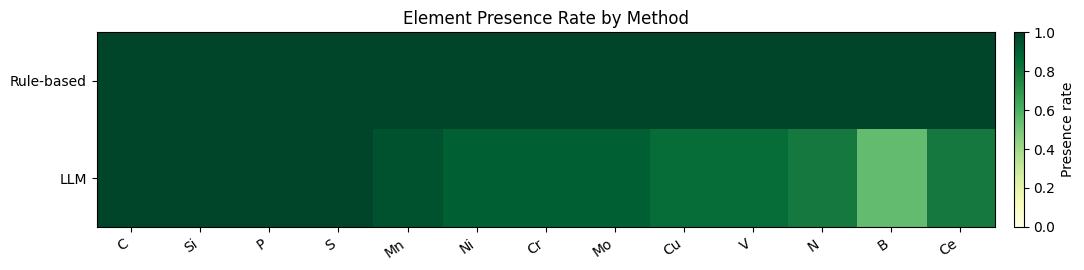

In [21]:
def element_presence_rates(data, elements):
    rows = data.get('chemical_composition', [])
    if not rows:
        return {e: 0.0 for e in elements}
    rates = {}
    for e in elements:
        present = 0
        for row in rows:
            source = row.get('elements', row)
            present += int(source.get(e) is not None)
        rates[e] = present / len(rows)
    return rates

rule_elem = element_presence_rates(rule_data, required_elements)
llm_elem = element_presence_rates(llm_data, required_elements)

elem_matrix = pd.DataFrame([rule_elem, llm_elem], index=['Rule-based', 'LLM'])
elem_matrix

fig, ax = plt.subplots(figsize=(11, 2.8))
im = ax.imshow(elem_matrix.values, cmap='YlGn', vmin=0, vmax=1, aspect='auto')
ax.set_xticks(np.arange(len(elem_matrix.columns)))
ax.set_xticklabels(elem_matrix.columns, rotation=35, ha='right')
ax.set_yticks(np.arange(len(elem_matrix.index)))
ax.set_yticklabels(elem_matrix.index)
ax.set_title('Element Presence Rate by Method')
cbar = plt.colorbar(im, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label('Presence rate')
plt.tight_layout()
plt.show()

### 7.5 Text Volume by Source and Page

Compares character and line counts across OCR/text artifacts in the repository.

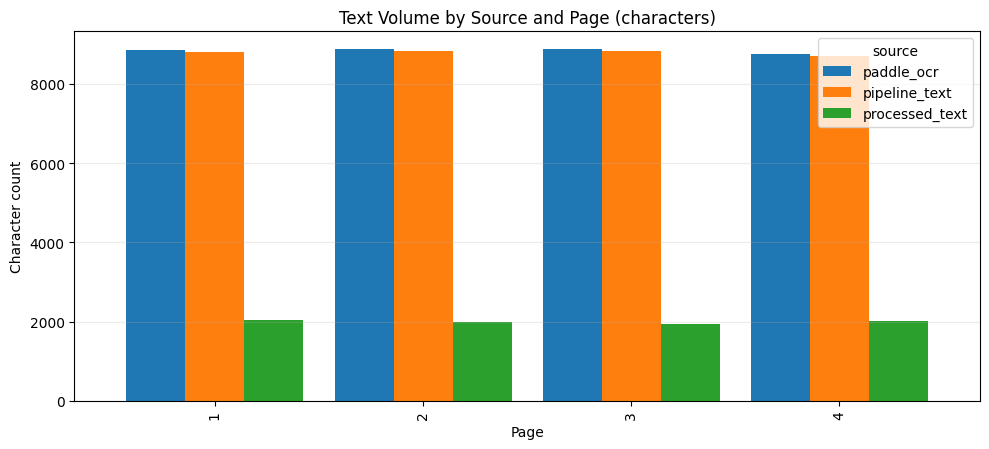

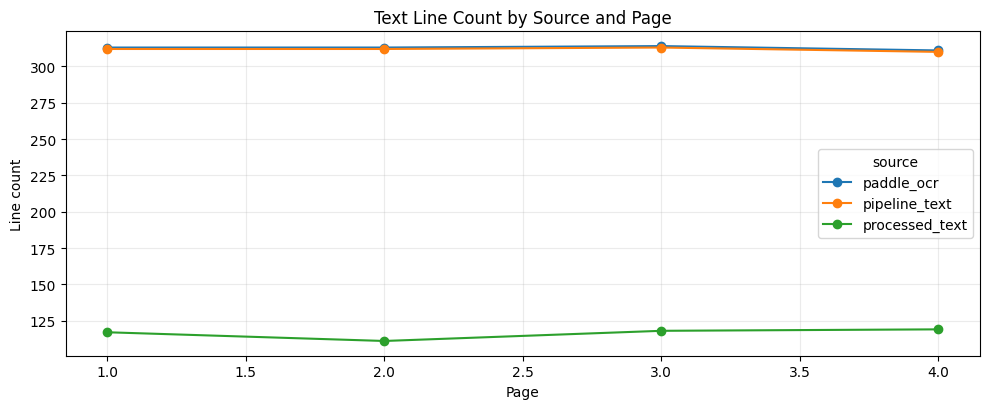

chars                lines           
                   mean    sum   max    mean   sum  max
source                                                 
paddle_ocr      8842.75  35371  8880  312.75  1251  314
pipeline_text   8789.75  35159  8827  311.75  1247  313
processed_text  1997.00   7988  2031  116.25   465  119

In [22]:
sources = {
    'processed_text': ROOT / 'data/processed/text',
    'paddle_ocr': ROOT / 'data/processed/paddle_ocr',
    'pipeline_text': ROOT / 'data/processed/pipeline_output/text',
}

records = []
for source_name, folder in sources.items():
    if not folder.exists():
        continue
    for p in sorted(folder.glob('*.txt')):
        page_match = re.search(r'page[_-]?(\d+)', p.stem)
        if not page_match:
            continue
        page = int(page_match.group(1))
        text = p.read_text(encoding='utf-8', errors='ignore')
        records.append({
            'source': source_name,
            'page': page,
            'chars': len(text),
            'lines': text.count('\n') + 1
        })

text_df = pd.DataFrame(records).sort_values(['source', 'page'])
text_df.head()

if not text_df.empty:
    pivot_chars = text_df.pivot_table(index='page', columns='source', values='chars', aggfunc='mean').fillna(0)
    ax = pivot_chars.plot(kind='bar', figsize=(10, 4.6), width=0.85)
    ax.set_title('Text Volume by Source and Page (characters)')
    ax.set_xlabel('Page')
    ax.set_ylabel('Character count')
    ax.grid(axis='y', alpha=0.25)
    plt.tight_layout()
    plt.show()

    pivot_lines = text_df.pivot_table(index='page', columns='source', values='lines', aggfunc='mean').fillna(0)
    ax = pivot_lines.plot(kind='line', figsize=(10, 4.2), marker='o')
    ax.set_title('Text Line Count by Source and Page')
    ax.set_xlabel('Page')
    ax.set_ylabel('Line count')
    ax.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

text_df.groupby('source')[['chars', 'lines']].agg(['mean', 'sum', 'max'])

## 8) Notes

- This notebook compares actual JSON outputs in `data/processed/schema_output`.
- If file names differ in your environment, update `RULE_PATH` and `LLM_PATH` in Cell 2.
- The metrics here are computed directly from output files and can be reused for future documents.
- New visual sections (Section 7) pull from repo-wide OCR boxes and text artifacts.